# Linear Neural Networks

In [21]:
import math
import time
import numpy as np
import torch
import matplotlib.pyplot as plt
import random

In [7]:
n = 10000
a = torch.ones(n)
b = torch.ones(n)

In [8]:
class Timer:
    def __init__(self):
        self.times = []
        self.start()
    def start(self):
        """Start the timer."""
        self.tik = time.time()
    def stop(self):
        """Stop the timer and record the time in a list."""
        self.times.append(time.time() - self.tik)
        return self.times[-1]
    def avg(self):
        """Return the average time."""
        return sum(self.times) / len(self.times)
    def sum(self):
        """Return the sum of time."""
        return sum(self.times)
    def cumsum(self):
        """Return the accumulated time."""
        return np.array(self.times).cumsum().tolist()

In [9]:
c = torch.zeros(n)
timer = Timer()
for i in range(n):
    c[i] = a[i] + b[i]
timer.stop()

0.06117510795593262

In [11]:
timer.start()
d = a + b
timer.stop()

0.00013399124145507812

In [13]:
def synthetic_data(w, b, num_examples):
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

In [15]:
true_w = torch.tensor([2., -3])
true_b = 5.
features, labels = synthetic_data(true_w, true_b, 1000)

In [17]:
features.shape, labels.shape

(torch.Size([1000, 2]), torch.Size([1000, 1]))

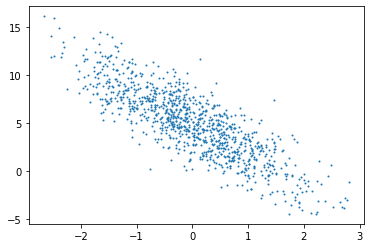

In [19]:
plt.scatter(features[:, 1].numpy(), labels.numpy(), 1)

In [22]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [36]:
batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X)
    print(y)
    break

tensor([[-0.6219,  0.4622],
        [ 0.2534, -0.0628],
        [-0.3414, -1.2409],
        [-0.0124, -1.7147],
        [-1.4079,  0.3657],
        [ 1.5588, -2.6618],
        [-0.1159, -1.4971],
        [-0.3177,  0.1415],
        [-0.9740, -0.9336],
        [-0.9134,  0.5921]])
tensor([[ 2.3780],
        [ 5.6880],
        [ 8.0410],
        [10.1275],
        [ 1.0925],
        [16.0966],
        [ 9.2400],
        [ 3.9496],
        [ 5.8493],
        [ 1.3981]])


In [37]:
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [38]:
def linreg(X, w, b):
    return torch.matmul(X, w) + b

In [39]:
def squared_loss(y_hat, y):
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

In [42]:
def sgd(params, lr, batch_size):
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

In [43]:
lr = 0.03 
num_epochs = 10
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y) # Minibatch loss in `X` and `y`
        # Compute gradient on `l` with respect to [`w`, `b`]
        l.sum().backward()
        sgd([w, b], lr, batch_size) # Update parameters using their gradient
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.045942
epoch 2, loss 0.000190
epoch 3, loss 0.000048
epoch 4, loss 0.000047
epoch 5, loss 0.000047
epoch 6, loss 0.000047
epoch 7, loss 0.000047
epoch 8, loss 0.000047
epoch 9, loss 0.000047
epoch 10, loss 0.000047


In [47]:
w.reshape(true_w.shape) - true_w

tensor([-0.0002, -0.0006], grad_fn=<SubBackward0>)

In [49]:
b - true_b

tensor([-0.0005], grad_fn=<SubBackward0>)

In [50]:
from torch.utils import data

In [51]:
def load_array(data_arrays, batch_size, is_train=True):
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

In [52]:
batch_size = 10
data_iter = load_array((features, labels), batch_size)

In [53]:
next(iter(data_iter))

[tensor([[-0.2800,  0.0553],
         [-1.5544, -0.0280],
         [ 1.0346, -0.2449],
         [ 0.0401, -0.7301],
         [ 0.3117, -0.5234],
         [-0.6047,  0.2521],
         [ 1.1804, -1.6580],
         [-0.5715, -0.8767],
         [-0.1714, -0.7465],
         [ 1.1876, -1.2635]]),
 tensor([[ 4.2859],
         [ 1.9764],
         [ 7.8027],
         [ 7.2793],
         [ 7.1807],
         [ 3.0499],
         [12.3478],
         [ 6.4918],
         [ 6.8994],
         [11.1691]])]

In [55]:
from torch import nn
net = nn.Sequential(nn.Linear(2, 1))

In [56]:
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

In [57]:
loss = nn.MSELoss()

In [59]:
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

In [61]:
num_epoch = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X), y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000354
epoch 2, loss 0.000095
epoch 3, loss 0.000096
epoch 4, loss 0.000095
epoch 5, loss 0.000095
epoch 6, loss 0.000095
epoch 7, loss 0.000095
epoch 8, loss 0.000095
epoch 9, loss 0.000096
epoch 10, loss 0.000095


In [63]:
net[0].weight.data.reshape(true_w.shape) - true_w

tensor([2.3055e-04, 8.9884e-05])

In [64]:
net[0].bias.data - true_b

tensor([-0.0008])

In [66]:
import torchvision
from torch.utils import data
from torchvision import transforms

In [67]:
trans = transforms.ToTensor()

In [68]:
mnist_train = torchvision.datasets.FashionMNIST(root='../data', 
                                                train=True, 
                                                transform=trans,
                                                download=True)
mnist_test = torchvision.datasets.FashionMNIST(root='../data', 
                                                train=False, 
                                                transform=trans,
                                                download=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



/Users/jielishen/opt/anaconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [69]:
len(mnist_train), len(mnist_test)

(60000, 10000)

In [74]:
mnist_train[0][0].shape

torch.Size([1, 28, 28])

In [75]:
def get_fashion_mnist_labels(labels):
    text_labels = [
    't-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt',
    'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

In [77]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5): #@save
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # Tensor Image
            ax.imshow(img.numpy())
        else:
            # PIL Image
            ax.imshow(img)
            ax.axes.get_xaxis().set_visible(False)
            ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

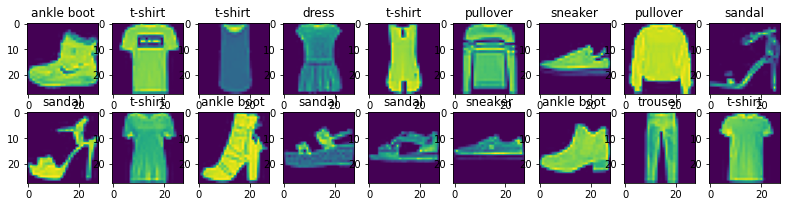

In [79]:
X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
_ = show_images(X.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_labels(y))

In [80]:
batch_size = 256
train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=4)

In [82]:
def load_data_fashion_mnist(batch_size, resize=None):
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(root="../data",
                                                    train=True,
                                                    transform=trans,
                                                    download=True)
    mnist_test = torchvision.datasets.FashionMNIST(root="../data",
                                                    train=False,
                                                    transform=trans,
                                                    download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=4),
        data.DataLoader(mnist_test, batch_size, shuffle=False, num_workers=4))

In [86]:
net = nn.Sequential(nn.Flatten(), nn.Linear(28 * 28, 10))
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)
net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
)

In [ ]:
def train_epoch_ch3(net, train_iter, loss, updater):
    if is

In [98]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)

In [92]:
trainer = torch.optim.SGD(net.parameters(), lr=0.01)

In [95]:
net = nn.Sequential(
    nn.Flatten(), 
    nn.Linear(28 * 28, 256),
    nn.ReLU(),
    nn.Linear(256, 10)
)

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)
net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=10, bias=True)
)

In [96]:
batch_size, lr, num_epochs = 256, 0.1, 10

In [97]:
loss = nn.CrossEntropyLoss()
trainer = torch.optim.SGD(net.parameters(), lr=lr)

In [ ]:
train_iter, test_iter = load_data_fashion_mnist(batch_size)
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)